[ pytorch Diamond 모델 ]

- 데이터셋 : diamonds.csv
- 학습방법 : 지도학습 + 분류 (다중분류)

< 모듈 및 파일 로딩 > <hr>

In [2]:
# [1-1] 모듈 로딩
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim      # 최적화 모듈 

from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader        ## 학습 데이터셋 관련 모듈
import torchmetrics.functional as mt
from torchmetrics.classification import *  # 분류 

In [3]:
# [1-2] 파일로딩
data_file = 'diamonds.csv'

dia_df = pd.read_csv(data_file, skipfooter=1, engine='python')

In [4]:
display(dia_df.head(2))

carat      cut color clarity  depth  table  price     x     y     z
0   0.23    Ideal     E     SI2   61.5   55.0    326  3.95  3.98  2.43
1   0.21  Premium     E     SI1   59.8   61.0    326  3.89  3.84  2.31

In [5]:
# 용어 정리
# carat : 캐럿, 다이아몬드의 무게 
# cut : 다이아몬드의 컷팅 품질
# color : 다이아몬드의 색상
# clarity : 다이아몬드 내부 결함이나 표면의 흠집을 나타내는 척도
# depth : 다이아몬드의 높이를 너비에 대한 백분율로 표현한 값
# table : 다이아몬드의 상단 면적 크기를 너비에 대한 백분율로 나타낸 값
# price : 다이아몬드의 가격
# x : 다이아몬드의 길이
# y : 다이아몬드의 너비
# z : 다이아몬드의 높이 

In [6]:
# [1-3] 데이터 확인 
dia_df.info()   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53939 entries, 0 to 53938
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53939 non-null  float64
 1   cut      53939 non-null  object 
 2   color    53939 non-null  object 
 3   clarity  53939 non-null  object 
 4   depth    53939 non-null  float64
 5   table    53939 non-null  float64
 6   price    53939 non-null  int64  
 7   x        53939 non-null  float64
 8   y        53939 non-null  float64
 9   z        53939 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


In [7]:
# [1-4] 결측치 확인
# info로 확인 결과, 결측치 없음 

In [8]:
# [1-5] 범주형 데이터 확인 
print(dia_df['color'].unique())
print(dia_df['cut'].unique())
print(dia_df['clarity'].unique())

['E' 'I' 'J' 'H' 'F' 'G' 'D']
['Ideal' 'Premium' 'Good' 'Very Good' 'Fair']
['SI2' 'SI1' 'VS1' 'VS2' 'VVS2' 'VVS1' 'I1' 'IF']


In [9]:
# [1-6] 범주형 데이터 수치화 1
pd.set_option('future.no_silent_downcasting',True)
labelToNum={'E': 0, 
    'I': 1, 
    'J': 2, 
    'H': 3, 
    'F': 4, 
    'G': 5, 
    'D': 6}

# 안전한 레이블 변환
dia_df['color'] = dia_df['color'].map(labelToNum)

# 변환이 잘 되었는지 확인
print(dia_df['color'].unique())  # [0 1 2 3 4 5 6]이 출력되어야 함

[0 1 2 3 4 5 6]


In [10]:
# [1-6] 범주형 데이터 수치화 2
pd.set_option('future.no_silent_downcasting',True)
labelToNum={'Fair': 0, 
    'Very Good': 1, 
    'Good': 2, 
    'Premium': 3, 
    'Ideal': 4, 
    }

# 안전한 레이블 변환
dia_df['cut'] = dia_df['cut'].map(labelToNum)

# 변환이 잘 되었는지 확인
print(dia_df['cut'].unique())  

[4 3 2 1 0]


In [11]:
# [1-6] 범주형 데이터 수치화 3
pd.set_option('future.no_silent_downcasting',True)
labelToNum={'SI2': 1, 
    'SI1': 2, 
    'VS1': 4, 
    'VS2': 3, 
    'VVS2': 5, 
    'VVS1': 6,
    'I1' : 0, 
    'IF' : 7}

# 안전한 레이블 변환
dia_df['clarity'] = dia_df['clarity'].map(labelToNum)

# 변환이 잘 되었는지 확인
print(dia_df['clarity'].unique())  

[1 2 4 3 5 6 0 7]


< 탐색적 분석 > <hr>

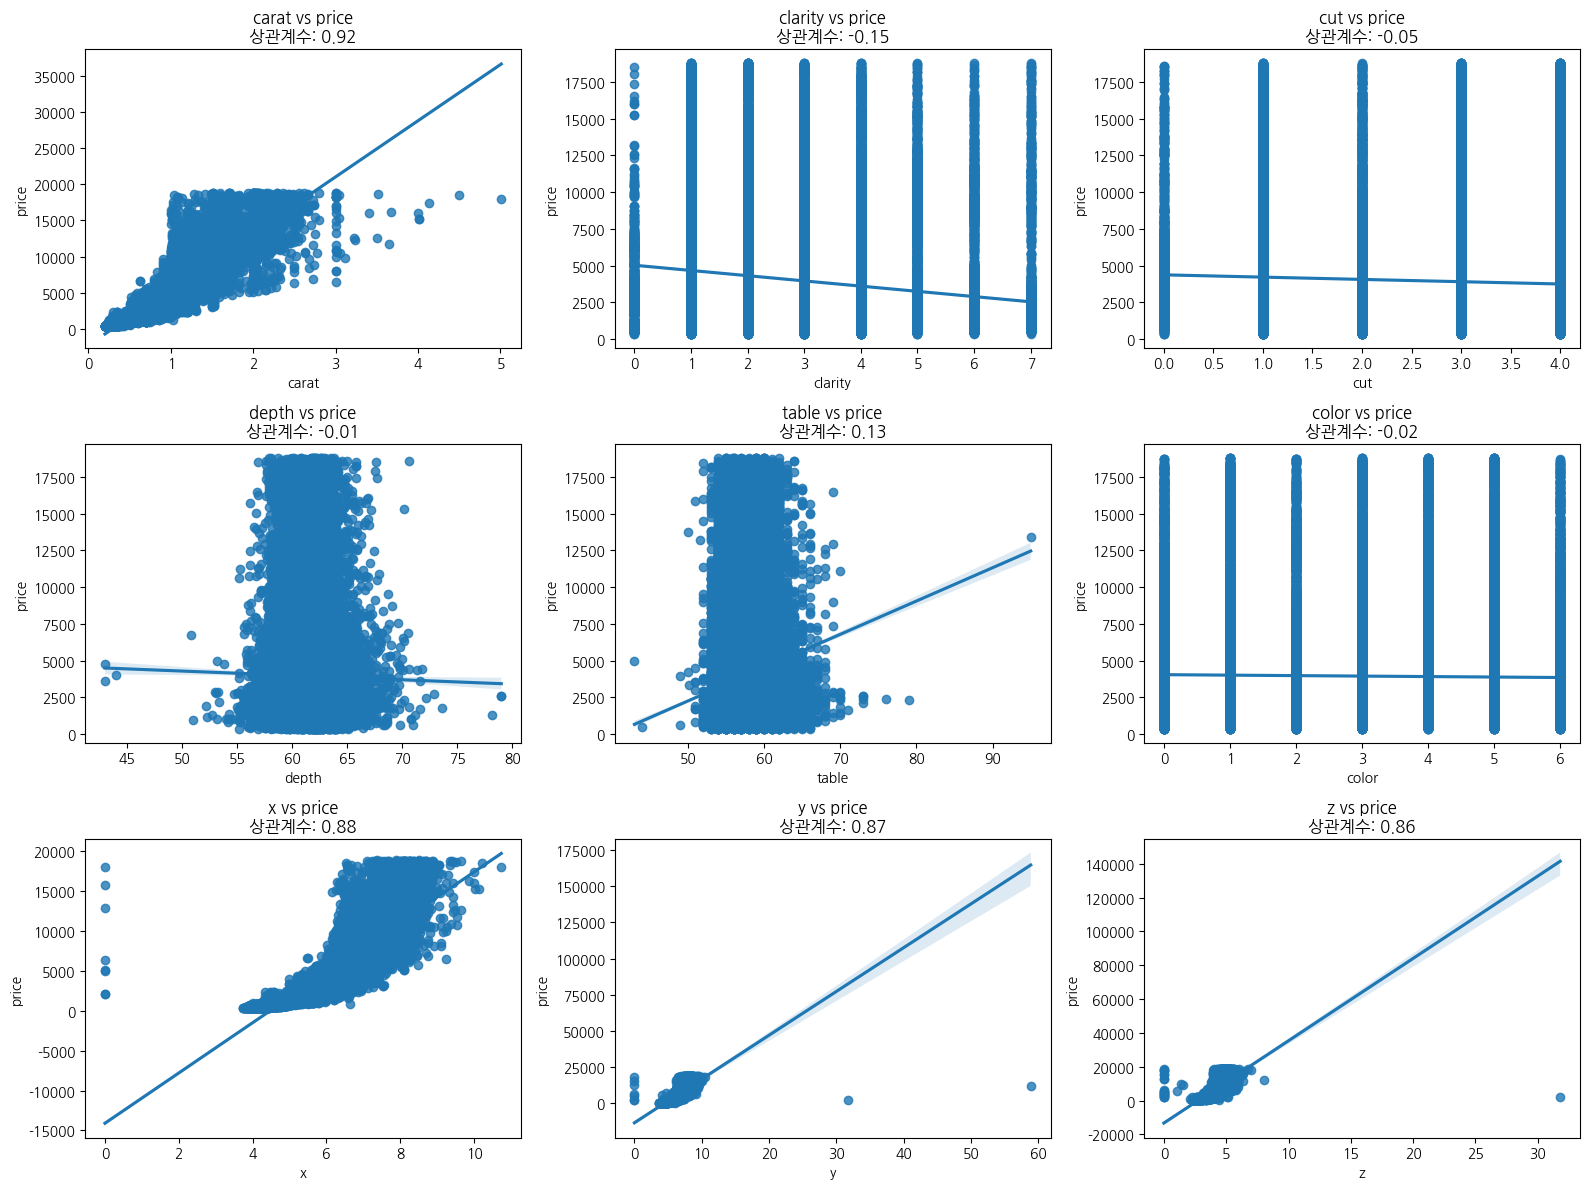

In [12]:
# [2-1] 탐색적 분석 - 상관계수 분석 
fig, axs = plt.subplots(figsize=(16,12), ncols=3, nrows=3)
features = ['carat', 'clarity', 'cut', 'depth', 'table', 'color', 'x', 'y', 'z']

# i는 인덱스, feature는 list안의 원소 하나씩 반환 
for i, feature in enumerate(features):
    row = int(i/3)
    col = i % 3
    
    # seaborn 'regplot' 활용해서 산점도와 선형 회귀 직선을 함께 표현 
    sns.regplot(x=feature, y='price', data=dia_df, ax=axs[row][col])
    
    # 피처와 타겟 간 상관계수 계산
    correlation = np.corrcoef(dia_df[feature].astype(float), dia_df['price'].astype(float))[0, 1]
    
    # 제목에 상관계수 포함
    axs[row][col].set_title(f"{feature} vs price\n상관계수: {correlation:.2f}")
    
plt.tight_layout()
plt.show()

In [13]:
# [2-2] 피쳐 컬럼 결정 : carat, x, y, z
dia_df = dia_df.drop(columns=['clarity', 'cut', 'depth', 'table', 'color'])
display(dia_df)

carat  price     x     y     z
0       0.23    326  3.95  3.98  2.43
1       0.21    326  3.89  3.84  2.31
2       0.23    327  4.05  4.07  2.31
3       0.29    334  4.20  4.23  2.63
4       0.31    335  4.34  4.35  2.75
...      ...    ...   ...   ...   ...
53934   0.72   2757  5.69  5.73  3.58
53935   0.72   2757  5.75  5.76  3.50
53936   0.72   2757  5.69  5.75  3.61
53937   0.70   2757  5.66  5.68  3.56
53938   0.86   2757  6.15  6.12  3.74

[53939 rows x 5 columns]

In [14]:
# [2-3] 타겟 컬럼 범주화
print(dia_df['price'].max())
print(dia_df['price'].min())

bins = [326, 1200, 4200, 18823]  # 구간 설정
labels = ['low', 'medium', 'high']  # 구간에 대한 이름
dia_df['category'] = pd.cut(dia_df['price'], bins=bins, labels=labels)

dia_df['category'].value_counts()  # 최대한 비율을 맞추려고 함


18823
326


category
high      18425
medium    17939
low       17573
Name: count, dtype: int64

In [15]:
# [2-4] 추가 결측치 제거
dia_df = dia_df.dropna()

dia_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53937 entries, 2 to 53938
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   carat     53937 non-null  float64 
 1   price     53937 non-null  int64   
 2   x         53937 non-null  float64 
 3   y         53937 non-null  float64 
 4   z         53937 non-null  float64 
 5   category  53937 non-null  category
dtypes: category(1), float64(4), int64(1)
memory usage: 2.5 MB


In [16]:
# [2-5] 범주형 데이터 수치화 4
pd.set_option('future.no_silent_downcasting',True)
labelToNum={'low': 0, 
    'medium': 1, 
    'high': 2
    }

# 안전한 레이블 변환
dia_df['category'] = dia_df['category'].map(labelToNum)

# 변환이 잘 되었는지 확인
print(dia_df['category'].unique())  

[0, 1, 2]
Categories (3, int64): [0 < 1 < 2]


< 데이터셋 준비 > <hr>

In [17]:
# [3-1] 피쳐 타겟 분리
featureDF = dia_df[['carat', 'x', 'y', 'z']]  
TargetSR = dia_df[dia_df.columns[-1]]

print(featureDF.shape)
print(TargetSR.shape)

(53937, 4)
(53937,)


In [18]:
# [3-2] 피쳐 전처리 : 데이터 타입 확인, 값의 범위 맞추기

# 데이터 타입 변경 float64 -> float32
featureDF = featureDF.astype('float32')
print(featureDF.dtypes)

carat    float32
x        float32
y        float32
z        float32
dtype: object


In [29]:
# [3-3] train test 데이터셋 분리
x_train, x_test, y_train, y_test = train_test_split(featureDF, 
                                                    TargetSR,
                                                    test_size=0.2,
                                                    stratify=TargetSR,
                                                    random_state=42)
                                    

In [30]:
# 학습용을 기준으로 정규화 진행 
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler  # 스케일링 모듈
# 연속형 피쳐 스케일링
columns_to_scale = ['carat', 'x', 'y', 'z']

mmScaler = MinMaxScaler()
mmScaler.fit(x_train)

scaled_x_train = mmScaler.transform(x_train)
scaled_x_test = mmScaler.transform(x_test)

x_train = pd.DataFrame(scaled_x_train, columns=columns_to_scale, index=x_train.index)
x_test = pd.DataFrame(scaled_x_test, columns=columns_to_scale, index=x_test.index)

In [31]:
x_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

x_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

In [32]:
# shape 확인
print(x_train.shape)
print(y_train.shape)

(43149, 4)
(43149,)


< 커스텀 데이터셋 클래스 설계 및 구현 > <hr>

In [33]:
# [4-1] 전용 데이터셋 클래스 
class DiaDataset(Dataset):
    # 피쳐와 타겟 분리 및 전처리 진행 
    def __init__(self, featureDF, targetSR):
        super().__init__()
        self.feature = featureDF
        self.target  = targetSR
        self.rows = featureDF.shape[0]
        self.cols = featureDF.shape[1]
    
    # 데이터셋의 샘플 수 반환 메서드 
    def __len__(self):
        return self.rows 

    # DataLoader에서 batch_size만큼 호출하는 메서드
    # 인덱스에 해당하는 피쳐와 타겟 반환 단, Tensor 형태
    def __getitem__(self, index):
       arrFeature = self.feature.iloc[index].values   # ndarray (1차원)
       arrTarget = self.target[index].reshape(-1)     # ndarray (1차원)
   
       return torch.FloatTensor(arrFeature), torch.LongTensor(arrTarget)

In [34]:
Dia_DS = DiaDataset(x_train,y_train)
len(Dia_DS)

43149

In [35]:
# [4-2] 확인 
# Train용 DataSet 필수 
# Test용 Dataset 선택  => 데이터가 많다면 DS, DL 생성 사용
#                     => 데이터가 많지 않다면 DS, DL 생성 필요 X 
trainDS = DiaDataset(x_train, y_train)
testDS  = DiaDataset(x_test, y_test)
print(trainDS[1])
print(testDS[2])

(tensor([0.2570, 0.6824, 0.1187, 0.5186]), tensor([2]))
(tensor([0.2519, 0.6775, 0.1177, 0.5174]), tensor([2]))


In [36]:
# [4-3] Train용 데이터로더
trainDL = DataLoader(dataset=trainDS, batch_size=3)
for feature, label in trainDL:
    print(feature, label)
    break

tensor([[0.2697, 0.6854, 0.1171, 0.5298],
        [0.2570, 0.6824, 0.1187, 0.5186],
        [0.2570, 0.6647, 0.1132, 0.5335]]) tensor([[2],
        [2],
        [2]])


In [37]:
# [4-4] Test용 데이터로더
testDL = DataLoader(dataset=testDS, batch_size=3)
for feature, label in testDL:
    print(feature, label, sep='\n')
    break

tensor([[0.0254, 0.4211, 0.0735, 0.3350],
        [0.1654, 0.6085, 0.1041, 0.4516],
        [0.2519, 0.6775, 0.1177, 0.5174]])
tensor([[0],
        [1],
        [2]])


< 모델 설계 및 클래스 구현 > <hr>

In [38]:
# [5-1] 모델 클래스 설계 
## - 클래스 이 름 : Multi_Model
## - 부 모 클래스 : nn.Module
## - 데 이  터 셋 : 피쳐 많음 , 타겟 10 , 타겟 범주형
## - 학습    방법 : 지도학습 - 분류(다중)
## - 구현알고리즘 : 인공신경망계열 DNN 
## -------------------------------------------------
##             입력       출력/퍼셉트론수    활성화함수
## - 입력층      4(피쳐)   1280               ReLU
## - 은닉층      1280      640                ReLU
## - 은닉층      640       320                ReLU
## - 출력층      320       3  (타겟)          Softmax
## 피쳐와 타겟을 제외하고 나머지는 사용자 지정 : 단, 초반에 퍼셉트론 수가 많은 것은 GOOD

In [39]:
# 클래스 생성
class Multi_Model(nn.Module):
    
    def __init__(self, in_in, in_out, h1_out, h2_out, out_out):
        super().__init__()
        pass
        
        self.input_layer = nn.Linear(in_in, in_out)
        self.hidden_layer1 = nn.Linear(in_out, h1_out)
        self.hidden_layer2 = nn.Linear(h1_out, h2_out)
        self.output_layer = nn.Linear(h2_out, out_out)
        
    
    # 순방향 학습 진행 메서드 : forward로 무조건 고정!!
    # forward : 필수 오버라이딩 메서드 
    # 매개변수 data : 학습용 데이터 전달
    
    # 입력층 학습 
    def forward(self,data):     
        output = self.input_layer(data)
        output = F.relu(output)
        
        output = self.hidden_layer1(output)
        output = F.relu(output)
        
        output = self.hidden_layer2(output)
        output = F.relu(output)
        
        output = self.output_layer(output)
    
        return output
        

In [40]:
# [5-2] 모델 구조 확인
model = Multi_Model(4,1280,640,320,3)

print(model)

Multi_Model(
  (input_layer): Linear(in_features=4, out_features=1280, bias=True)
  (hidden_layer1): Linear(in_features=1280, out_features=640, bias=True)
  (hidden_layer2): Linear(in_features=640, out_features=320, bias=True)
  (output_layer): Linear(in_features=320, out_features=3, bias=True)
)


< 학습 준비 > <hr>

In [41]:
# [6-1] 학습 관련 설정들
EPOCHS = 50               # 학습용 DS를 처음부터 끝까지 50번 학습
BATCH_SIZE = 128          # DS를 학습량 만큼 나눈 사이즈
ITERATION = int(x_train.shape[0]/BATCH_SIZE)             # 학습용 DS가 분리된 수 => 1 에포크에 W,b 업데이트 횟수 
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'  # 학습, 데이터셋 로딩 등 GPU에서 실행 여부 설정  

print(f'EPOCHS : {EPOCHS}')
print(f'BATCH_SIZE : {BATCH_SIZE}')
print(f'ITERATION : {ITERATION}')
print(f'DEVICE : {DEVICE}')

EPOCHS : 50
BATCH_SIZE : 128
ITERATION : 337
DEVICE : cpu


In [42]:
# [6-2] 학습 관련 인스턴스들 
LR = 0.01                                           # 학습률 (0.01)
MODEL = Multi_Model(4,1280,640,320,3)               # 학습 모델
OPTIMIZER = optim.Adam(MODEL.parameters(), lr=LR)   # 최적화, 즉 경사하강법 알고리즘으로 W,b의 값 갱신 
LOSS_FN = nn.CrossEntropyLoss()                     # 다중분류 손실계산 인스턴스

TRAINDL = DataLoader(trainDS, batch_size=BATCH_SIZE)
TESTDL = DataLoader(testDS,  batch_size=BATCH_SIZE)

In [43]:
# [6-3] 검증 함수
# - 검증용 데이터셋으로 모델 검증
# - 학습 지속여부 결정 기준이 됨

def evaluate():
    # 에포크 단위로 검증 => 검증 모드
    MODEL.eval()
    
    # W, b가 업데이트 해제
    with torch.no_grad():
        T_LOSS, T_ACC, CNT = 0, 0, 0
        for feature, target in TESTDL:            
            # 검증진행
            pre_y = MODEL(feature)
            
            # 손실 계산
            loss = LOSS_FN(pre_y, target.reshape(-1).long())
            
            # 정확도 계산
            Accuracy = MulticlassAccuracy(num_classes=3)
            acc = Accuracy(pre_y,target.reshape(-1))
            
            T_LOSS += loss.item()  # Loss 누적 / 텐서로 담지 않기 위함 - 스칼라로 담기
            T_ACC += acc.item()    # 정확도 누적 
            CNT += 1
        
        return T_LOSS/CNT, T_ACC/CNT

In [44]:
# [6-4] 학습 함수
def training():
    # 학습 모드 설정
    model.train()

    E_LOSS, E_ACC = 0, 0
    #for i in range(ITERATION): 
    for feature, target in TRAINDL:
                                                                    
        # 가중치 기울기 0 초기화
        OPTIMIZER.zero_grad()

        # 학습 진행
        pre_y = MODEL(feature)

        # 손실 계산
        loss = LOSS_FN(pre_y, target.reshape(-1).long())
        
        # 정확도 계산
        Accuracy = MulticlassAccuracy(num_classes=3)
        acc = Accuracy(pre_y,target.reshape(-1))
        
        # 역전파 진행
        loss.backward()

        # 가중치/절편 업데이트
        OPTIMIZER.step()

        E_LOSS += loss.item()
        E_ACC += acc.item()

    return E_LOSS/ITERATION, E_ACC/ITERATION

In [45]:
# [6-5] 학습 / 검증 동시 진행 

# 에포크 : DS 처음부터 ~ 끝까지 학습
HIST = {'Train':[], 'Valid':[]}   

# 에포크 단위 학습/검증 진행 
for epoch in range(EPOCHS):
    trainLoss, trainacc = training()
    validLoss, validacc = evaluate()

    HIST['Train'].append((trainLoss,trainacc))
    HIST['Valid'].append((validLoss,validacc))

    print(f'\nEPOCH[{epoch+1}/{EPOCHS}]----------------')
    print(f'- TRAIN_LOSS {trainLoss:.5f}')
    print(f'- VALID_LOSS {validLoss:.5f}')
    print('-------------------------------')
    print(f'- TRAIN_Accuracy {trainacc:.5f}')
    print(f'- VALID_Accuracy {validacc:.5f}')


EPOCH[1/50]----------------
- TRAIN_LOSS 0.32240
- VALID_LOSS 0.29811
-------------------------------
- TRAIN_Accuracy 0.88187
- VALID_Accuracy 0.88613

EPOCH[2/50]----------------
- TRAIN_LOSS 0.26441
- VALID_LOSS 0.26592
-------------------------------
- TRAIN_Accuracy 0.90426
- VALID_Accuracy 0.90493

EPOCH[3/50]----------------
- TRAIN_LOSS 0.25746
- VALID_LOSS 0.28412
-------------------------------
- TRAIN_Accuracy 0.90796
- VALID_Accuracy 0.89658

EPOCH[4/50]----------------
- TRAIN_LOSS 0.25653
- VALID_LOSS 0.26340
-------------------------------
- TRAIN_Accuracy 0.90747
- VALID_Accuracy 0.90261

EPOCH[5/50]----------------
- TRAIN_LOSS 0.25364
- VALID_LOSS 0.26452
-------------------------------
- TRAIN_Accuracy 0.91004
- VALID_Accuracy 0.90510

EPOCH[6/50]----------------
- TRAIN_LOSS 0.25557
- VALID_LOSS 0.26349
-------------------------------
- TRAIN_Accuracy 0.90895
- VALID_Accuracy 0.90419

EPOCH[7/50]----------------
- TRAIN_LOSS 0.25290
- VALID_LOSS 0.25722
-----------

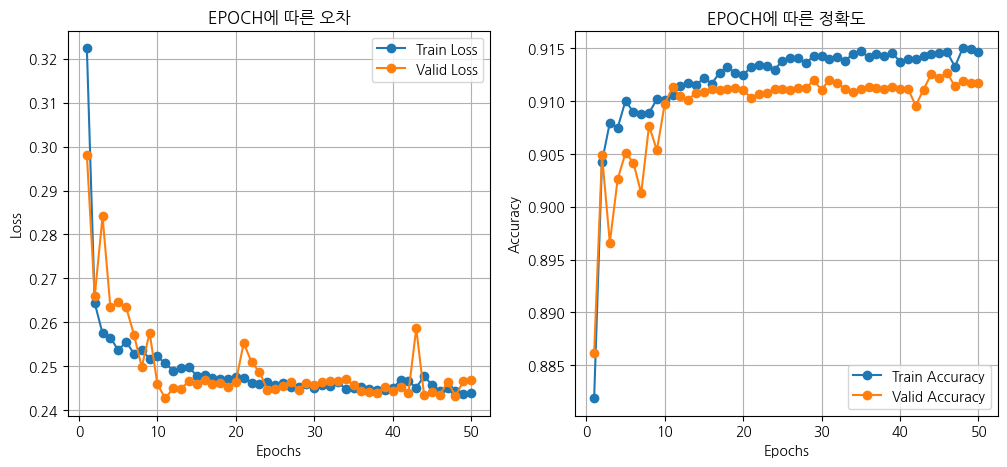

In [46]:
# [6-6] 시각화 
import matplotlib.pyplot as plt
import koreanize_matplotlib

# 에포크 수 설정
epochs = len(HIST['Train'])

# Loss 그래프
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), [x[0] for x in HIST['Train']], label='Train Loss', marker='o')
plt.plot(range(1, epochs+1), [x[0] for x in HIST['Valid']], label='Valid Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('EPOCH에 따른 오차')
plt.legend()
plt.grid(True)

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), [x[1] for x in HIST['Train']], label='Train Accuracy', marker='o')
plt.plot(range(1, epochs+1), [x[1] for x in HIST['Valid']], label='Valid Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('EPOCH에 따른 정확도')
plt.legend()
plt.grid(True)

plt.show()